In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K

Using TensorFlow backend.


In [2]:
folder_benign_train = r'C:\Users\15301070\Desktop\data\train\benign'
folder_malignant_train = r'C:\Users\15301070\Desktop\data\train\malignant'

folder_benign_test = r'C:\Users\15301070\Desktop\data\test\benign'
folder_malignant_test = r'C:\Users\15301070\Desktop\data\test\malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


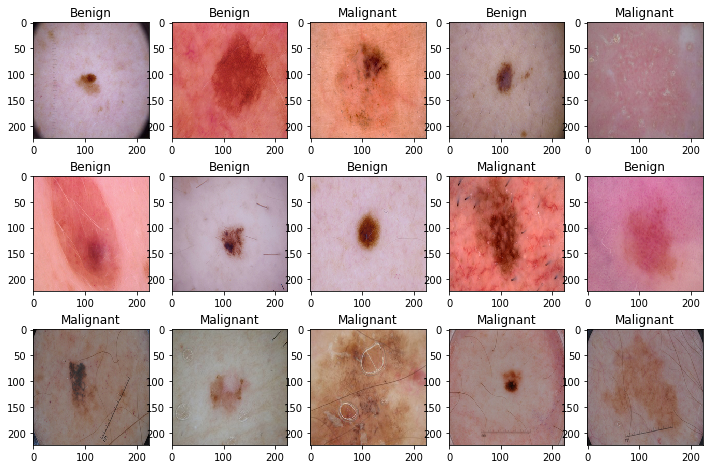

In [3]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [4]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [5]:
X_train = X_train/255.
X_test = X_test/255.

In [6]:
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [7]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)           

In [8]:
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 143s 68ms/step - loss: 1.4674 - accuracy: 0.4998 - val_loss: 0.9998 - val_accuracy: 0.4602
Epoch 2/50
2109/2109 [==============================] - 118s 56ms/step - loss: 1.1595 - accuracy: 0.5282 - val_loss: 0.6806 - val_accuracy: 0.5398
Epoch 3/50
2109/2109 [==============================] - 117s 55ms/step - loss: 1.0331 - accuracy: 0.5709 - val_loss: 0.6593 - val_accuracy: 0.5814
Epoch 4/50
2109/2109 [==============================] - 114s 54ms/step - loss: 0.9565 - accuracy: 0.5718 - val_loss: 0.6384 - val_accuracy: 0.6402
Epoch 5/50
2109/2109 [==============================] - 113s 54ms/step - loss: 0.8950 - accuracy: 0.5946 - val_loss: 0.5840 - val_accuracy: 0.7481
Epoch 6/50
2109/2109 [==============================] - 113s 54ms/step - loss: 0.8382 - accuracy: 0.6003 - val_loss: 0.5711 - val_accuracy: 0.7614
Epoch 7/50
2109/2109 [==============================] - 114s 54ms/step 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


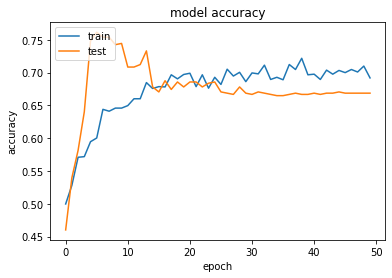

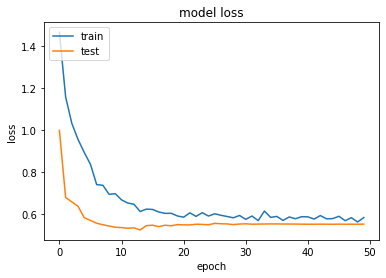

In [9]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
K.clear_session()
del model
del history

In [11]:
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=1)
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)           

In [12]:
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=1,
          callbacks=[learning_rate_reduction]
         )

y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)           

C:\Users\15301070\.conda\envs\ffs\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2637/2637 [==============================] - 133s 50ms/step - loss: 0.9476 - accuracy: 0.5563
Epoch 3/50
2637/2637 [==============================] - 134s 51ms/step - loss: 0.9026 - accuracy: 0.5745
Epoch 4/50
2637/2637 [==============================] - 133s 50ms/step - loss: 0.8211 - accuracy: 0.5980
Epoch 5/50
2637/2637 [==============================] - 133s 50ms/step - loss: 0.7607 - accuracy: 0.6223
Epoch 6/50
2637/2637 [==============================] - 133s 50ms/step - loss: 0.7108 - accuracy: 0.6568
Epoch 7/50
2637/2637 [==============================] - 134s 51ms/step - loss: 0.6753 - accuracy: 0.6610
Epoch 8/50
2637/2637 [==============================] - 133s 51ms/step - loss: 0.6767 - accuracy: 0.6640
Epoch 9/50
2637/2637 [==============================] - 132s 50ms/step - loss: 0.6326 - accuracy: 0.6871
Epoch 10/50
2637/2637 [==============================] - 133s 51ms/step - loss: 0.6104 - accuracy: 0.6940
Epoch 11/50
2637/2637 [==============================] - 135s 51m

In [13]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("Saved model to disk")

del model
K.clear_session()

Saved model to disk


Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 1324s 628ms/step - loss: 0.9733 - accuracy: 0.6098 - val_loss: 8.2255 - val_accuracy: 0.4640
Epoch 2/50
2109/2109 [==============================] - 1111s 527ms/step - loss: 0.5582 - accuracy: 0.7568 - val_loss: 0.6805 - val_accuracy: 0.5530
Epoch 3/50
2109/2109 [==============================] - 1096s 520ms/step - loss: 0.4486 - accuracy: 0.7819 - val_loss: 0.6607 - val_accuracy: 0.5663
Epoch 4/50
2109/2109 [==============================] - 1098s 521ms/step - loss: 0.4244 - accuracy: 0.7824 - val_loss: 0.6386 - val_accuracy: 0.5966
Epoch 5/50
2109/2109 [==============================] - 1099s 521ms/step - loss: 0.4000 - accuracy: 0.7918 - val_loss: 0.6062 - val_accuracy: 0.6004
Epoch 6/50
2109/2109 [==============================] - 1099s 521ms/step - loss: 0.3747 - accuracy: 0.8217 - val_loss: 0.6013 - val_accuracy: 0.6212
Epoch 7/50
2109/2109 [==============================] - 109

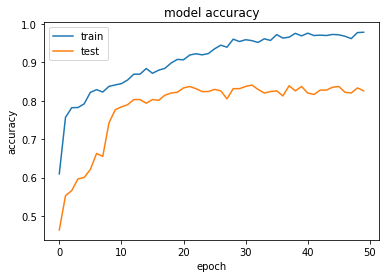

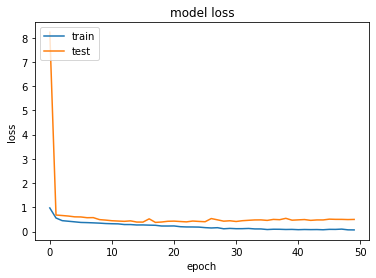

In [14]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
model.save_weights("resnet50.h5")
print("Saved model to disk")

0.8242424242424242
Saved model to disk


In [9]:
del model
K.clear_session()

Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 977s 463ms/step - loss: 0.6874 - accuracy: 0.5548 - val_loss: 0.6888 - val_accuracy: 0.5114
Epoch 2/50
2109/2109 [==============================] - 967s 459ms/step - loss: 0.6580 - accuracy: 0.5624 - val_loss: 0.6308 - val_accuracy: 0.5928
Epoch 3/50
2109/2109 [==============================] - 962s 456ms/step - loss: 0.5889 - accuracy: 0.6894 - val_loss: 0.5444 - val_accuracy: 0.7424
Epoch 4/50
2109/2109 [==============================] - 960s 455ms/step - loss: 0.5087 - accuracy: 0.7482 - val_loss: 0.4947 - val_accuracy: 0.7614
Epoch 5/50
2109/2109 [==============================] - 959s 455ms/step - loss: 0.4910 - accuracy: 0.7534 - val_loss: 0.5031 - val_accuracy: 0.7595
Epoch 6/50
2109/2109 [==============================] - 960s 455ms/step - loss: 0.4772 - accuracy: 0.7667 - val_loss: 0.4707 - val_accuracy: 0.7803
Epoch 7/50
2109/2109 [==============================] - 959s 455m

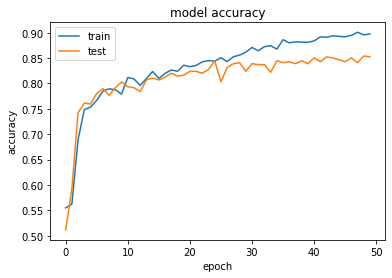

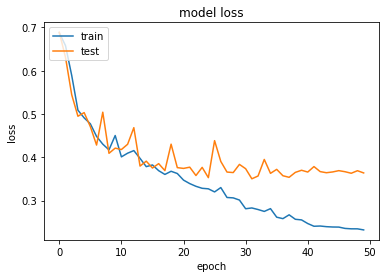

In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np


input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = VGG16(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [11]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

vgg16_json = model.to_json()

with open("vgg16.json", "w") as json_file:
    json_file.write(vgg16_json)
    
model.save_weights("vgg16.h5")
print("Saved model to disk")

del model
K.clear_session()

0.8424242424242424
Saved model to disk


Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 534s 253ms/step - loss: 0.5810 - accuracy: 0.6785 - val_loss: 0.6929 - val_accuracy: 0.5114
Epoch 2/50
2109/2109 [==============================] - 452s 214ms/step - loss: 0.4441 - accuracy: 0.7909 - val_loss: 0.6936 - val_accuracy: 0.5114
Epoch 3/50
2109/2109 [==============================] - 452s 214ms/step - loss: 0.4020 - accuracy: 0.8061 - val_loss: 0.7013 - val_accuracy: 0.5114
Epoch 4/50
2109/2109 [==============================] - 453s 215ms/step - loss: 0.3687 - accuracy: 0.8231 - val_loss: 0.7363 - val_accuracy: 0.5114
Epoch 5/50
2109/2109 [==============================] - 453s 215ms/step - loss: 0.3553 - accuracy: 0.8374 - val_loss: 0.7788 - val_accuracy: 0.5114
Epoch 6/50
2109/2109 [==============================] - 455s 216ms/step - loss: 0.3466 - accuracy: 0.8321 - val_loss: 0.9451 - val_accuracy: 0.5114

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.99999

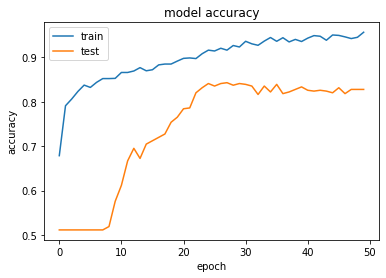

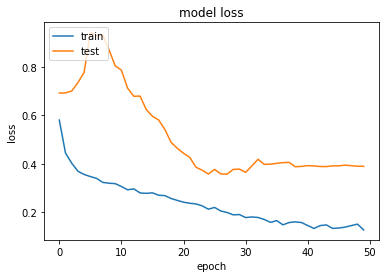

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input


input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = InceptionV3(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [14]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

inception_v3_json = model.to_json()

with open("inception_v3.json", "w") as json_file:
    json_file.write(inception_v3_json)
    
model.save_weights("inception_v3.h5")
print("Saved model to disk")

del model
K.clear_session()

0.8378787878787879
Saved model to disk


Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 1235s 586ms/step - loss: 0.6862 - accuracy: 0.5524 - val_loss: 0.6873 - val_accuracy: 0.5114
Epoch 2/50
2109/2109 [==============================] - 1218s 578ms/step - loss: 0.6447 - accuracy: 0.5813 - val_loss: 0.6037 - val_accuracy: 0.6458
Epoch 3/50
2109/2109 [==============================] - 1223s 580ms/step - loss: 0.5346 - accuracy: 0.7397 - val_loss: 0.4814 - val_accuracy: 0.7708
Epoch 4/50
2109/2109 [==============================] - 1219s 578ms/step - loss: 0.5201 - accuracy: 0.7501 - val_loss: 0.5108 - val_accuracy: 0.7708
Epoch 5/50
2109/2109 [==============================] - 1217s 577ms/step - loss: 0.5042 - accuracy: 0.7549 - val_loss: 0.6090 - val_accuracy: 0.6932
Epoch 6/50
2109/2109 [==============================] - 1220s 579ms/step - loss: 0.4866 - accuracy: 0.7615 - val_loss: 0.4699 - val_accuracy: 0.7841
Epoch 7/50
2109/2109 [==============================] - 122

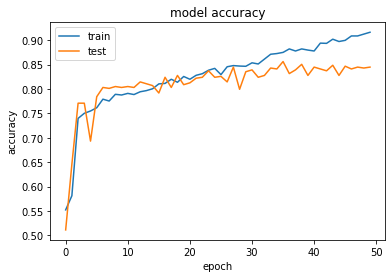

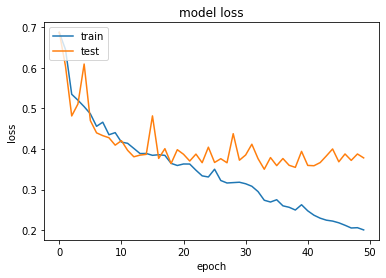

In [17]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np


input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = VGG19(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [18]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

vgg19_json = model.to_json()

with open("vgg19.json", "w") as json_file:
    json_file.write(vgg19_json)
    
model.save_weights("vgg19.h5")
print("Saved model to disk")

del model
K.clear_session()

0.8454545454545455
Saved model to disk


Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 1301s 617ms/step - loss: 0.4889 - accuracy: 0.7790 - val_loss: 0.6928 - val_accuracy: 0.5360
Epoch 2/50
2109/2109 [==============================] - 1192s 565ms/step - loss: 0.3940 - accuracy: 0.8146 - val_loss: 0.6924 - val_accuracy: 0.5360
Epoch 3/50
2109/2109 [==============================] - 1206s 572ms/step - loss: 0.3631 - accuracy: 0.8307 - val_loss: 0.6920 - val_accuracy: 0.5360
Epoch 4/50
2109/2109 [==============================] - 1177s 558ms/step - loss: 0.3472 - accuracy: 0.8355 - val_loss: 0.6916 - val_accuracy: 0.5360
Epoch 5/50
2109/2109 [==============================] - 1148s 544ms/step - loss: 0.3301 - accuracy: 0.8492 - val_loss: 0.6911 - val_accuracy: 0.5360
Epoch 6/50
2109/2109 [==============================] - 1161s 551ms/step - loss: 0.3071 - accuracy: 0.8596 - val_loss: 0.6906 - val_accuracy: 0.5360

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4

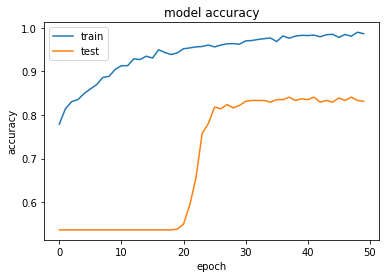

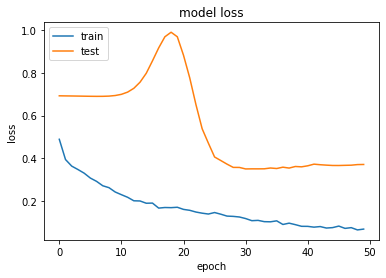

In [10]:
from keras.applications.xception import Xception


input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = Xception(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

xception_json = model.to_json()

with open("xception.json", "w") as json_file:
    json_file.write(xception_json)
    
model.save_weights("xception.h5")
print("Saved model to disk")

del model
K.clear_session()

0.853030303030303
Saved model to disk


Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 464s 220ms/step - loss: 0.7059 - accuracy: 0.5756 - val_loss: 0.6927 - val_accuracy: 0.5360
Epoch 2/50
2109/2109 [==============================] - 437s 207ms/step - loss: 0.6396 - accuracy: 0.6145 - val_loss: 0.6923 - val_accuracy: 0.5360
Epoch 3/50
2109/2109 [==============================] - 432s 205ms/step - loss: 0.5925 - accuracy: 0.6524 - val_loss: 0.6919 - val_accuracy: 0.5360
Epoch 4/50
2109/2109 [==============================] - 432s 205ms/step - loss: 0.5496 - accuracy: 0.7037 - val_loss: 0.6914 - val_accuracy: 0.5360
Epoch 5/50
2109/2109 [==============================] - 431s 204ms/step - loss: 0.5157 - accuracy: 0.7416 - val_loss: 0.6911 - val_accuracy: 0.5360
Epoch 6/50
2109/2109 [==============================] - 432s 205ms/step - loss: 0.5034 - accuracy: 0.7368 - val_loss: 0.6907 - val_accuracy: 0.5360

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.99999

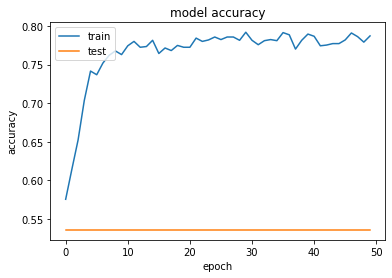

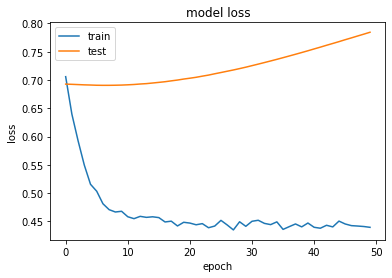

In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2


input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = MobileNetV2(include_top=True,
                 alpha = 1.0,
                 weights = None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

mobilenet_v2_json = model.to_json()

with open("mobilenet_v2.json", "w") as json_file:
    json_file.write(mobilenet_v2_json)
    
model.save_weights("mobilenet_v2.h5")
print("Saved model to disk")

del model
K.clear_session()

0.5454545454545454
Saved model to disk


Train on 2109 samples, validate on 528 samples
Epoch 1/50
2109/2109 [==============================] - 390s 185ms/step - loss: 0.7424 - accuracy: 0.5548 - val_loss: 0.6911 - val_accuracy: 0.5360
Epoch 2/50
2109/2109 [==============================] - 382s 181ms/step - loss: 0.6920 - accuracy: 0.5718 - val_loss: 0.6906 - val_accuracy: 0.5360
Epoch 3/50
2109/2109 [==============================] - 382s 181ms/step - loss: 0.6637 - accuracy: 0.5970 - val_loss: 0.6915 - val_accuracy: 0.5360
Epoch 4/50
2109/2109 [==============================] - 380s 180ms/step - loss: 0.6505 - accuracy: 0.6112 - val_loss: 0.6941 - val_accuracy: 0.5360
Epoch 5/50
2109/2109 [==============================] - 381s 180ms/step - loss: 0.6381 - accuracy: 0.6321 - val_loss: 0.6979 - val_accuracy: 0.5360
Epoch 6/50
2109/2109 [==============================] - 381s 181ms/step - loss: 0.6259 - accuracy: 0.6302 - val_loss: 0.7036 - val_accuracy: 0.5360

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.99999

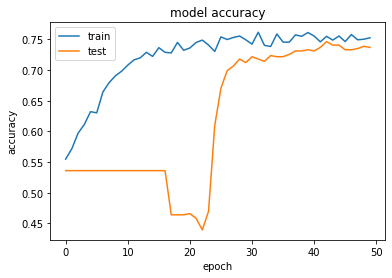

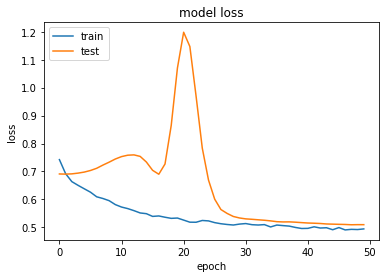

In [8]:
from keras.applications.mobilenet import MobileNet


input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = MobileNet(include_top=True,
                 alpha = 1.0,
                 weights = None,
                 depth_multiplier=1,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

mobilenet_json = model.to_json()

with open("mobilenet.json", "w") as json_file:
    json_file.write(mobilenet_json)
    
model.save_weights("mobilenet.h5")
print("Saved model to disk")

del model
K.clear_session()

0.75
Saved model to disk
